### Classifying and predicting early hospital readmissions:

Classifying with supervised learning whether diabetic patients are readmitted, and if they are, if it's before or after 30 days.

Using the dataset from here: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

In [1]:
from fastai.tabular import * 
from fastai.callbacks import *
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
from imblearn.over_sampling import SMOTENC

Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
dep_var = 'early_readmit'

In [4]:
with open("x_2_with_categoricals.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

with open("y_2.pkl", 'rb') as picklefile: 
    df[dep_var] = pickle.load(picklefile)

In [5]:
np.unique(list(df[dep_var]))

array(['<30', '>30', 'NO'], dtype='<U3')

In [6]:
len(df)

100114

In [7]:
cat_names = list(df.select_dtypes(exclude=["number","bool_"]).columns)
cat_names.remove(dep_var)

In [8]:
df.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,early_readmit
0,Caucasian,Female,0,0,NULL,Not Mapped,Physician Referral,1,UNK,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,10,0,Emergency,Discharged to home,Emergency Room,3,UNK,UNK,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,20,0,Emergency,Discharged to home,Emergency Room,2,UNK,UNK,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,30,0,Emergency,Discharged to home,Emergency Room,2,UNK,UNK,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,40,0,Emergency,Discharged to home,Emergency Room,1,UNK,UNK,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [9]:
df[dep_var] = df[dep_var].replace({'<30':1, '>30':0, 'NO':0})
df.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,early_readmit
0,Caucasian,Female,0,0,NULL,Not Mapped,Physician Referral,1,UNK,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,10,0,Emergency,Discharged to home,Emergency Room,3,UNK,UNK,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,AfricanAmerican,Female,20,0,Emergency,Discharged to home,Emergency Room,2,UNK,UNK,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,30,0,Emergency,Discharged to home,Emergency Room,2,UNK,UNK,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,40,0,Emergency,Discharged to home,Emergency Room,1,UNK,UNK,...,No,Steady,No,No,No,No,No,Ch,Yes,0


In [10]:
procs = [FillMissing, Categorify, Normalize]

In [11]:
df, X_test, df[dep_var], y_test = train_test_split(df, df[dep_var], test_size=0.2, random_state=42, stratify=df[dep_var])

In [12]:
numerical_cols = list(df.select_dtypes(["number","bool_"]).columns)
numerical_cols.remove(dep_var)

In [13]:
# train_idx, valid_idx = next(StratifiedKFold(n_splits=10).split(df, df[dep_var]))

In [14]:
X_train, X_val, y_train, y_val = train_test_split(df, df[dep_var], 
                                                   test_size=0.25, 
                                                   random_state=42, 
                                                   stratify=df[dep_var],
                                                   shuffle=True)

In [15]:
# standard scale
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

## SMOTENC oversampling:

In [16]:
len(X_val)

20023

In [17]:
X_train.shape

(60068, 48)

In [18]:
# [df.columns.get_loc(c) for c in cols if c in df]
[df.columns.get_loc(c) for c in cat_names if c in df]

[0,
 1,
 4,
 5,
 6,
 8,
 9,
 16,
 17,
 18,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46]

In [19]:
X_train.dtypes

race                         object
gender                       object
age                         float64
weight                      float64
admission_type_id            object
discharge_disposition_id     object
admission_source_id          object
time_in_hospital            float64
payer_code                   object
medical_specialty            object
num_lab_procedures          float64
num_procedures              float64
num_medications             float64
number_outpatient           float64
number_emergency            float64
number_inpatient            float64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses            float64
max_glu_serum                object
A1Cresult                    object
metformin                    object
repaglinide                  object
nateglinide                  object
chlorpropamide               object
glimepiride                  object
acetohexamide               

In [20]:
sm = SMOTENC(random_state=42, categorical_features=[df.columns.get_loc(c) for c in cat_names if c in df])
# rus = RandomUnderSampler(random_state=42)
x_sm, y_sm = sm.fit_resample(X_train, y_train)
X_train = pd.DataFrame(x_sm, columns = X_train.columns)

In [21]:
X_train.shape

(106508, 48)

In [22]:
X_train.dtypes

race                        object
gender                      object
age                         object
weight                      object
admission_type_id           object
discharge_disposition_id    object
admission_source_id         object
time_in_hospital            object
payer_code                  object
medical_specialty           object
num_lab_procedures          object
num_procedures              object
num_medications             object
number_outpatient           object
number_emergency            object
number_inpatient            object
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses            object
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide           

In [23]:
X_train.columns

Index(['race', 'gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'early_readmit'],
      dtype='object')

In [24]:
X_train[dep_var] = X_train[dep_var].apply(pd.to_numeric, errors='coerce')
X_train[dep_var] = X_train[dep_var].astype(int)

In [25]:
X_train[numerical_cols] = X_train[numerical_cols].apply(pd.to_numeric, errors='coerce')

In [26]:
np.array(X_train[dep_var])

array([0, 0, 1, 0, ..., 1, 1, 1, 1])

In [27]:
np.array(X_test[dep_var])

array([0, 1, 1, 0, ..., 0, 0, 0, 0])

In [28]:
np.array(X_val[dep_var])

array([0, 0, 0, 0, ..., 0, 0, 0, 0])

In [29]:
df = pd.concat([X_val,X_train], ignore_index=True)

In [30]:
valid_idx=range(0,len(X_val)-1)
valid_idx

range(0, 20022)

In [31]:
# SMOTE doesn't work for categoricals currently

# smote = SMOTE()
# x_sm, y_sm = smote.fit_sample(df, df[dep_var])
# df = pd.DataFrame(x_sm, columns=df.columns)
# df[dep_var] = y_sm

In [32]:
data = TabularDataBunch.from_df(df=df, 
                                test_df=X_test, 
                                path='.', 
                                dep_var=dep_var, 
                                valid_idx=valid_idx, 
                                procs=procs,
                                cat_names=cat_names)

In [33]:
len(data.train_ds)

106509

In [34]:
len(data.valid_ds)

20022

In [35]:
len(data.test_ds)

20023

In [36]:
callback_fns = [ShowGraph, 
#                 SaveModelCallback(learn, every='improvement', monitor='val_loss', name='fastaimodel'),
                partial(EarlyStoppingCallback, monitor='val_loss', min_delta=0.01, patience=4)]

In [37]:
# dictionary = dict(zip(keys, values))
emb_szs = dict(zip(cat_names, [600]*len(cat_names)))
emb_szs

{'race': 600,
 'gender': 600,
 'admission_type_id': 600,
 'discharge_disposition_id': 600,
 'admission_source_id': 600,
 'payer_code': 600,
 'medical_specialty': 600,
 'diag_1': 600,
 'diag_2': 600,
 'diag_3': 600,
 'max_glu_serum': 600,
 'A1Cresult': 600,
 'metformin': 600,
 'repaglinide': 600,
 'nateglinide': 600,
 'chlorpropamide': 600,
 'glimepiride': 600,
 'acetohexamide': 600,
 'glipizide': 600,
 'glyburide': 600,
 'tolbutamide': 600,
 'pioglitazone': 600,
 'rosiglitazone': 600,
 'acarbose': 600,
 'miglitol': 600,
 'troglitazone': 600,
 'tolazamide': 600,
 'examide': 600,
 'citoglipton': 600,
 'insulin': 600,
 'glyburide-metformin': 600,
 'glipizide-metformin': 600,
 'glimepiride-pioglitazone': 600,
 'metformin-rosiglitazone': 600,
 'metformin-pioglitazone': 600,
 'change': 600,
 'diabetesMed': 600}

In [38]:
def calcHiddenLayer(data, alpha, numHiddenLayers):
  tempData = data.train_ds
  i, o = len(tempData.x.classes), len(tempData.y.classes)
  io = i+o
  return [(len(data.train_ds)//(alpha*(io)))//numHiddenLayers]*numHiddenLayers

In [39]:
# for numHiddenLayers in [2,3,4,5]:
#     for alpha in [2,3,4,5,6,7,8,9,10]:
#         print(calcHiddenLayer(data, alpha, numHiddenLayers))

In [40]:
calc_layers = calcHiddenLayer(data, 2, 8)
calc_layers

[170, 170, 170, 170, 170, 170, 170, 170]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


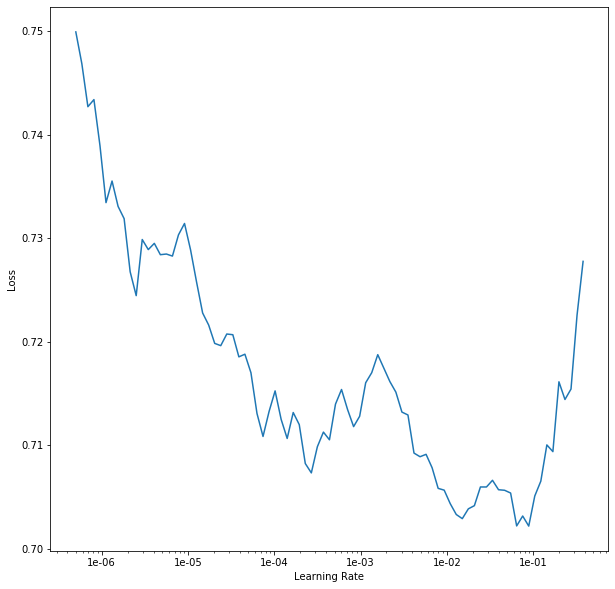

In [41]:
# Create deep learning model
learn = tabular_learner(data, 
#                         layers=[1000,650,500,250,125,100,100,100,50,25,10], 
                        layers=[2000,1000,500,100],
#                         layers=[2000,2000,1000,1000],
#                         layers=[200,100],
#                         layers=calc_layers,
                        metrics=[AUROC()],
#                         emb_szs=emb_szs,
                        emb_drop=0.3, 
                        callback_fns=callback_fns)
# learn.data.add_test(X_test)

# select the appropriate learning rate
learn.lr_find(end_lr=1)

# we typically find the point where the slope is steepest
learn.recorder.plot()

epoch,train_loss,valid_loss,auroc,time
0,0.442792,0.524462,0.580591,02:07


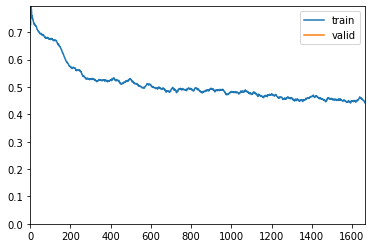

/usr/local/anaconda3/lib/python3.7/site-packages/fastai/callbacks/tracker.py:50: UserWarning: <class 'fastai.callbacks.tracker.EarlyStoppingCallback'> conditioned on metric `val_loss` which is not available. Available metrics are: train_loss, valid_loss, auroc
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:-1]))}')


epoch,train_loss,valid_loss,auroc,time
0,0.426488,0.517704,0.582295,02:07
1,0.425617,0.512059,0.589412,02:07
2,0.423470,0.522211,0.587029,02:07
3,0.424895,0.518808,0.590265,02:07
4,0.423622,0.487707,0.589790,02:07
5,0.416606,0.496840,0.594367,02:07
6,0.407339,0.539695,0.592626,02:08
7,0.396368,0.503452,0.587891,02:07
8,0.389965,0.483790,0.593453,02:08
9,0.384319,0.494591,0.591708,02:07


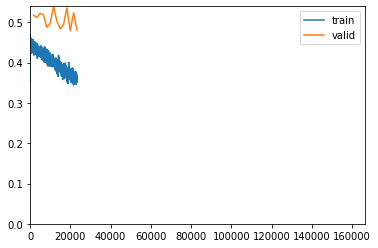

In [ ]:
# Fit the model based on selected learning rate
learn.fit_one_cycle(1, max_lr=1e-02)

learn.fit(epochs=100, lr=2e-4)

# Analyse our model
learn.model
learn.recorder.plot_losses()

In [ ]:
y_preds_probas, y = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
y_pred = torch.argmax(y_preds_probas, dim=1)

In [ ]:
y_pred = np.array(y_pred)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

In [ ]:
# np.array(list(y_preds_probas))[:,0]
np.array(y_preds_probas[:,1])

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
# y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
# y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

# fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
# auc_train = roc_auc_score(y_train, y_train_preds)

# fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
# auc_valid = roc_auc_score(y_valid, y_valid_preds)

# fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
# auc_test = roc_auc_score(y_test, y_test_preds)

# plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
# plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
# plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred)
auc_test = roc_auc_score(y_test, y_pred)
plt.plot(fpr_test, tpr_test, 'r-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
p, r, t = precision_recall_curve(y_test, np.array(y_preds_probas[:,1]))

# adding last threshold of '1' to threshold list
t = np.vstack([t.reshape([-1, 1]), 1])

plt.plot(t, p)
plt.plot(t, r)
plt.title('Precision Recall Curve')

In [ ]:
class_names = ["not early readmit", "early readmit"]

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=sns.color_palette("Blues")):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    ax = sns.heatmap(cm, cmap = cmap, annot=True, xticklabels=classes, yticklabels=classes)

    ax.set(title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the x labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Vertically center y labels
    plt.setp(ax.get_yticklabels(), va="center")
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    return ax

In [ ]:
# Plot non-normalized confusion matrix
ax = plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# plt.savefig('confusion_matrix_test.png', bbox_inches="tight")

In [ ]:
def feature_importance(learner): 
  # based on: https://medium.com/@mp.music93/neural-networks-feature-importance-with-fastai-5c393cf65815
    data = learner.data.train_ds.x
    cat_names = data.cat_names
    cont_names = data.cont_names
    loss0=np.array([learner.loss_func(learner.pred_batch(batch=(x,y.to("cpu"))), y.to("cpu")) for x,y in iter(learner.data.valid_dl)]).mean()
    fi=dict()
    types=[cat_names, cont_names]
    for j, t in enumerate(types):
      for i, c in enumerate(t):
        loss=[]
        for x,y in iter(learner.data.valid_dl):
          col=x[j][:,i]    #x[0] da hier cat-vars
          idx = torch.randperm(col.nelement())
          x[j][:,i] = col.view(-1)[idx].view(col.size())
          y=y.to('cpu')
          loss.append(learner.loss_func(learner.pred_batch(batch=(x,y)), y))
        fi[c]=np.array(loss).mean()-loss0
    d = sorted(fi.items(), key=lambda kv: kv[1], reverse=True)
    return pd.DataFrame({'cols': [l for l, v in d], 'imp': np.log1p([v for l, v in d])})
  
## my model is called 'learn'
features = feature_importance(learn)

## plot 'em!
features.plot('cols', 'imp', 'barh', figsize=(12,15), legend=False)

In [ ]:
features

In [ ]:
features['abs'] = [abs(elem) for elem in features['imp']]
features.sort_values(by='abs', ascending=False).head(10)